# AML Assignment 3

Federico Alberici, n. 808058

In [ ]:
!pip install livelossplot

## Setup phase
- import the needed library
- set the seed for numpy and tensorflow backend

In [ ]:
# remove pillow package

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.util import random_noise
from matplotlib import pyplot as plt
from livelossplot import PlotLossesKeras

np.random.seed(42)
tf.random.set_seed(42)

## Data preparation phase

First of all we proceed to import the MNIST dataset and then we scale the image into the [0;1] range to speed up the learning process. 

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Model/data parameters
num_classes = 10
input_shape = (28,28,1)

# Scale images into the [0 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

11493376/11490434 [==============================] - 0s 0us/step
60000 train samples
10000 test samples


As regularization technique **data augmentation** is choosed because is a simple yet powerfull method to improve accuracy over validation and test set. 
In images below we can se the augmented data for the sample classified as a two:
- the first is the original image;
- in the second gaussian noise is added;
- in the third salt and pepper noise is added.

Original image (class=2):


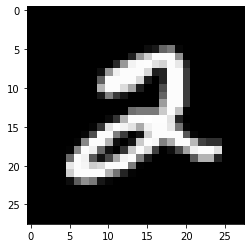

With gaussian noise:


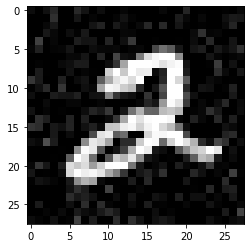

With s&p noise:


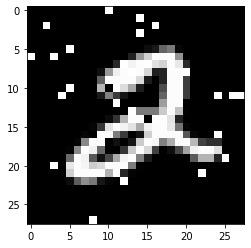

In [ ]:
# Let's augment the dataset by adding new gaussian noised images
def add_noise(img, mode:str):
    noised_img = random_noise(image=img, mode=mode, seed=42, clip=True)
    return noised_img

# Visualize a noised image
print(f'Original image (class={y_train[5]}):')
plt.imshow(x_train[5]*255, cmap='gray')
plt.show()

print('With gaussian noise:')
plt.imshow(add_noise(x_train[5], 'gaussian')*255, cmap='gray')
plt.show()

print('With s&p noise:')
plt.imshow(add_noise(x_train[5], 's&p')*255, cmap='gray')
plt.show()

For each training sample the gaussian and s&p noised version is added to the training set, tripling it's size.

In [ ]:
x_train_noised = []
y_train_noised = []
for i in range(0,x_train.shape[0]):
    imgs = [
        x_train[i], 
        add_noise(x_train[i], 'gaussian'), 
        add_noise(x_train[i], 's&p')
        ]
    labels = [y_train[i], y_train[i], y_train[i]]
    x_train_noised.extend(imgs)
    y_train_noised.extend(labels)
x_train_noised = np.array(x_train_noised)
y_train_noised = np.array(y_train_noised)

# Then shuffle it
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

shuffle_in_unison(x_train_noised, y_train_noised)

In [ ]:
# Make images with size (28,28,1)
x_train_noised = np.expand_dims(x_train_noised, -1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train_noised.shape)
print(x_train_noised.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train_noised = keras.utils.to_categorical(y_train_noised, num_classes)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (180000, 28, 28, 1)
180000 train samples
10000 test samples


## Model definition

The model is composed by 3 convolutional layer, followed by a single fully connected layer that map each input to the predicted class.
Let's see each layer in details:

### First CL
Composed by a 1x1x6 filter for dimensionality reduction, followed by a 3x3x6 filter and a 3x3 max pooling layer.

### Second CL
Composed by a 1x1x14 filter for dimensionality reduction, followed by a 3x3x14 filter and a 2x2 max pooling layer. the number of filters is **approximately** (because size constraint) doubled compared to the previous layer.

### Third CL
Composed by a 1x1x28 filter for dimensionality reduction, followed by a 2x2x28 filter and a dropout layer with probability of 0.5. the number of filters is **exactly** doubled compared to the previous layer.

### FC layer
The last convolutional layer is flattened and than fully connected to the 10 neuron (equal to the number of classes) output layer, with softmax activation function.


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(6, kernel_size=(1, 1), activation="relu"),
        layers.Conv2D(6, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(14, kernel_size=(1, 1), activation="relu"),
        layers.Conv2D(14, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(28, kernel_size=(1, 1), activation="relu"),
        layers.Conv2D(28, kernel_size=(2, 2), activation="relu"),
        layers.Dropout(0.5),
        layers.Flatten(),        
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 6)         12        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 26, 6)         330       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 6)           0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 14)          98        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 6, 6, 14)          1778      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 14)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 3, 3, 28)         

## Model training and results visualization

Finally the model is trained and the loss and the accuracy is plotted in live to visualize better how the training is going.
As optimizer Adam is choosed for is well known great performance in most of learning tasks. Actually the learning rate is a little bit smaller from the keras default (0.001) to stabilize the learning when the optimization is converging. The small learning rate is not a problem because the model is limited to only 7k parameter, so the iterations are very fast.

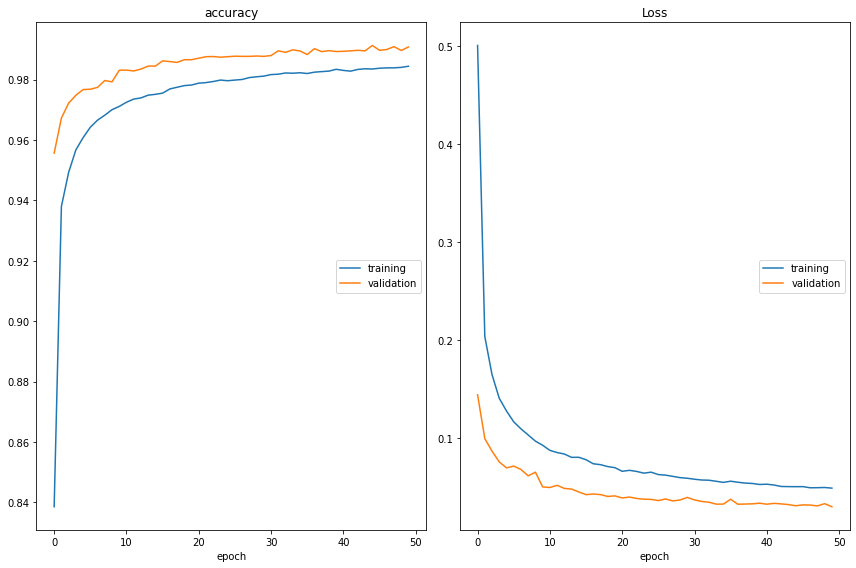

accuracy
	training         	 (min:    0.839, max:    0.984, cur:    0.984)
	validation       	 (min:    0.956, max:    0.991, cur:    0.991)
Loss
	training         	 (min:    0.049, max:    0.501, cur:    0.049)
	validation       	 (min:    0.030, max:    0.144, cur:    0.030)


In [ ]:
batch_size = 64
epochs = 50
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0005), metrics=["accuracy"])
model.fit(
    x_train_noised, 
    y_train_noised, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=0.1,
    verbose=0,
    callbacks=[PlotLossesKeras()])

The accuracy obtained in the test set is close to 99%, a very good result! Maybe we can get a little more just by adding more epochs in the training phase, always being careful for overfitting.

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0364 - accuracy: 0.9892


[0.036363713443279266, 0.9891999959945679]